In [20]:
#Import libraries

import os
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib
from pathlib import Path
%matplotlib inline
from PIL import Image
from math import floor, ceil
import cv2
from PIL import Image

plt.rcParams["figure.figsize"] = 12, 8

# Cayula -> Single Day MUR Data

### Import the data (Just one day of MUR data)

In [56]:
base_path = os.getcwd()
xarray_folder = os.path.join(base_path, "../data/MUR_single_days/sst_20190609.nc")  

data_xarray = xr.load_dataset(xarray_folder)

#In the case the temperature is in Kelvin (Convert to Celsius)
data_xarray['analysed_sst'] = data_xarray['analysed_sst'] - 273.15

data_xarray

<xarray.Dataset>
Dimensions:       (lat: 1001, lon: 1401, time: 1)
Coordinates:
  * time          (time) datetime64[ns] 2019-06-09T09:00:00
  * lat           (lat) float32 35.0 35.01 35.02 35.03 ... 44.98 44.99 45.0
  * lon           (lon) float32 -19.0 -18.99 -18.98 -18.97 ... -5.02 -5.01 -5.0
Data variables:
    analysed_sst  (time, lat, lon) float32 20.2 20.15 20.11 ... 15.05 15.05
Attributes: (12/47)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

### Cayula-Cornillon Algorithm

In [10]:

def getFrontInWindow(w, head, minTheta, minPopProp, minPopMeanDiff, minSinglePopCohesion, 
                     minGlobalPopCohesion, corners):
    
    """
    This functions detects fronts in slidding windows. If a front is detected, the function will return
    2 1D arrays (x and y) with the coordinate values corresponding to the location of the front.
    """
    
    #empty arrays de xdata, ydata e z
    xdata, ydata = np.array([]), np.array([])
    exitType=0
    
    #mask is an array with the same shape of w, that is 1 if in that index position w = np.nan and 0 otherwise
    mask = np.isnan(w).astype('int')  
    haveNaNs = np.any(mask[:]).astype('int')  #haveNaNs=1 if mask has 1s (that correspond to NaNs in matrix w)
    n_NaNs=0
    
    
    if haveNaNs:
        n_NaNs = sum(mask.flatten()[:])                 # count nr of 1s (NaNs in matrix w) that there are
        if (n_NaNs/len(w.flatten())>0.5):               #window can't have more than 50% of its pixels as NaNs
            exitType=-1
            return None,None,None,exitType  
        
    mi_ma = [np.nanmin(w), np.nanmax(w)]                          #array with minimum and maximum value of w
    n = ceil((mi_ma[1]-mi_ma[0])/0.02)                            #number of bins
    bins = np.arange(mi_ma[0], mi_ma[1], 0.02)                    #to define the bins sequence 
    [y, xout] = np.histogram(w[:], bins, mi_ma)                   #y->frequency counts, Xout->bin location
    xout = np.mean(np.vstack([xout[0:-1],xout[1:]]), axis=0)      #xout to be relative to the centers of the bins
    
    try:
        thresValue = xout[0]  
    except:
        thresValue = 0
        
          
    totalCount = len(w.flatten()) - n_NaNs                                       #nr of non NaN pixels 
    threshPopACount, threshSeparation, threshPopAMean, threshPopBMean  = 0, -1, 0, 0
 
    w[mask==1] = 0                                   #Replace NaNs with 0's (when mask is 1 replace values of array w for 0)
    totalSum = sum(w.flatten())                      #sum of values of matrix w
    totalSumSquares = sum(w.flatten()*w.flatten())   #sum of the squares of the values of w
    
    #In this for loop we are going to discover which line is going to make the best separation between the average
    # of population on the left and on the right (A and B) - and that is going to be the thresValue
    for k in range(1,n-1):                          #ignore the first and last candidates (senão seria de 0 a n)
        popASum = sum(y[0:k+1] * xout[0:k+1])    
        popBSum = sum(y[k+1:] * xout[k+1:])  
        popACount = sum(y[0:k+1])                   #sum of frequencies (y) from populationA
        popBCount = sum(y[k+1:])                    #sum of frequencies (y) from populationB
    
        popAMean = popASum/popACount
        try:                                  #to avoid the zerodivisionerror that was poping up 
            popBMean = popBSum/popBCount
        except ZeroDivisionError:
            popBMean = 0
        separation = popACount * popBCount * (popAMean - popBMean) * (popAMean - popBMean)
        if separation>threshSeparation:
            threshSeparation = separation
            thresValue = xout[k]
            threshPopACount = popACount
            threshPopAMean = popAMean
            threshPopBMean = popBMean
            
         
    #abort in case the proportion of population A is less that a certain minimum OR in case the proportion of population B is less that a certain minimum
    if (threshPopACount / totalCount < minPopProp) or (1.0 - threshPopACount / totalCount < minPopProp):
        exitType = 1
        return None,None, None, exitType  
    
    #abort this window if the difference in the populations means is less than a minimum value
    if (threshPopBMean - threshPopAMean < minPopMeanDiff):   
        exitType = 2
        return None,None,None,exitType  
    
    #Calculate the criterion function THETA (TAUopt) in page 72 of the paper
    totalMean = totalSum/totalCount
    variance = totalSumSquares - (totalMean * totalMean * totalCount)
    theta = threshSeparation / (variance * totalCount)
    if (theta < minTheta):         #abort if theta is lower than a certain minimum  
        exitType = 3
        return None,None,None,exitType  
    
#Cohesion - now that we know the separation value. Based on this value we will check the matrix element by 
#element, and check whether is bigger or lower than the separation  
#we check if it's bigger bellow or to the right (when its bigger we add from one side, when its lower add to the other)
#Count the nr of times a population A cell is immediately adjacent to another popA cell and the same for popB
# A cell can be adjacent on 4 sides. Count only 2 of them (bottom and right side) because doing all 4 would be
#redundant. Do not count diagonal neighbors
    countANextToA, countBNextToB, countANextToAOrB, countBNextToAOrB  = 0, 0, 0, 0
    [n_rows, n_cols] = w.shape
    for col in range(0, n_cols-1):
        for row in range(0, n_rows-1):
            if (haveNaNs & (mask[row, col] | mask[row+1, col] | mask[row, col+1])):
                continue
                         
            #examine the bottom neighbor
            if (w[row, col] <= thresValue):                  #if matrix pixel < than the element of separation
                countANextToAOrB = countANextToAOrB + 1      #increase by 1 countANextToAOrB
                if (w[row+1, col] <= thresValue):            #if pixel of bottom row < than separation
                    countANextToA = countANextToA + 1        #increase countANextToA
            else:                                            #if pixel > than separation 
                countBNextToAOrB = countBNextToAOrB + 1      #increase countBNextToAOrB
                if (w[row+1, col] > thresValue):             #if pixel of bellow row > separation
                    countBNextToB = countBNextToB + 1        #increase countBNextToB
                         
                         
            # Examine the right neighbor
            if (w[row, col] <= thresValue):                     #if matrix pixel < separation      
                countANextToAOrB = countANextToAOrB + 1         # increase countANextToAOrB
                if (w[row, col+1] <= thresValue):               #if right pixel < separation
                    countANextToA = countANextToA + 1           # increase countANextToA
            else:                                               #if matrix pixel > separation
                countBNextToAOrB = countBNextToAOrB + 1         #increase countBNextToAOrB
                if (w[row, col+1] > thresValue):                #if right pixel > separation
                    countBNextToB = countBNextToB +1            # increase countBNextToB
                         
                         
    popACohesion = countANextToA / countANextToAOrB
    popBCohesion = countBNextToB/ countBNextToAOrB
    globalCohesion = (countANextToA + countBNextToB) / (countANextToAOrB + countBNextToAOrB)
    
    #These ifs are in case of errors (parameters below certain limits)
    if (popACohesion < minSinglePopCohesion) or (popBCohesion < minSinglePopCohesion) or (globalCohesion < minGlobalPopCohesion):
        exitType = 4
        return None, None,None,exitType  
                         
                         
    #OK if we reach here we have a front. Compute its contour
    X = np.linspace(head[0], head[1], n_cols)    
    Y = np.linspace(head[2], head[3], n_rows)
    if (corners.size == 0):
        w = w.astype('double')    
        if haveNaNs:
            w[w==0] = np.nan      # Need to restore the NaNs to not invent new contours around zeros
        
        c = plt.contour(X, Y, w, [thresValue])    #Create and store a set of contour lines or filled regions.
    else:
        #the 4 corners have these indices [17,32,17,32; 17,32,1,16; 1,16,1,16;1,16,17,32]
        # and the variable corners has one of its rows (the current to be retained sub-window)
        
        X = X[np.arange(corners[2]-1, corners[3])]
        Y = Y[np.arange(corners[0]-1, corners[1])]
        w = w[np.arange(corners[0], corners[1]).min()-1:np.arange(corners[0], corners[1]).max()+1, np.arange(corners[2], corners[3]).min()-1:np.arange(corners[2], corners[3]).max()+1]
        
        if  haveNaNs:
            w[w==0] = np.nan     # Need to restore the NaNs to not invent new contours around zeros
                         
        if (np.isnan(w)).all()==True:
            c = np.array([])
        else:
            c = plt.contour(X, Y, w, [thresValue])     #Create and store a set of contour lines or filled regions.
                     
                
        #breakpoint()
        try:
            M = c.allsegs[:]          #list of arrays for contour c. Each array corresponds to a line that may or may not be drawn. This list can have any number of arrays
        except:
            M = []
            
        M = [x for x in M if x]   #if the list has empty arrays we will drop them
        
        count = 0   #to iterate through the various arrays
        
        #Create list of booleans (True or False) wether the conditions bellow are fulfilled
        # Each array (line of contour) must have more that 7 data points and they can't be closed lines
        lista = []     
        for i in range(len(M[:])):
            lista.append([(len(x)<7 or (x[0][0]==x[-1][0] and x[0][1] == x[-1][1])) for x in M[:][i]])
            
            #if False the line will be drawn
            #if True the line will be ignored
            
        for value in lista:
            if value == [True]:
                continue        #return to the top of the for loop
            else:                    
                #For the first array of M we will take all the values of x and put them into an array                    
                x = [(M[:][count][0][i][0]).round(4) for i in range(len(M[:][count][0]))]
                
                #For the first array of M we will take all the values of y and put them into an array                    
                y = [(M[:][count][0][i][1]).round(4) for i in range(len(M[:][count][0]))]
                
                
                #save the x and y data points for each line in an xdata and ydata array
                xdata, ydata = np.append(xdata, x), np.append(ydata, y)
                
                count += 1
            
        z = thresValue
        
        if (xdata.size == 0):
            exitType = 5
            
    return xdata, ydata, z, exitType

In [11]:
       
def CCA_SIED(data_xarray):
    
    """
    This function applies the Cayula-Cornillon Algorithm Single Image Edge Detector (CCA_SIED) to a single image
    with data from an xarray.
    For a single image, the function return the fronts coordinates (x,y) points 
    """
    #start_algorithm = time()
    
    #convert the latitude and longitude columns to a numpy array
    lat = data_xarray['lat'].values
    lon = data_xarray['lon'].values
    
    lat_min, lat_max, lon_min, lon_max = lat.min(), lat.max(), lon.min(), lon.max()  
    
    X, Y = np.meshgrid(lon, lat)                              #create rectangular grid out of two given 1D arrays

    lat = Y.T
    lon = X.T
    
    #Z = data_xarray['analysed_sst'][0].values - 273.15
    Z = data_xarray['analysed_sst'][0].values
    
    head = np.array([lon_min, lon_max], dtype='float64')           
    head = np.append(head, [lat_min, lat_max])  

    z_dim = Z.shape                                                 #dimensions/shape of matrix Z (rows, cols)

    z_actual_range = np.array([np.nanmin(Z[:]), np.nanmax(Z[:])])   #range of data (minimum and maximum of matrix Z)
    nx = z_dim[1]                                                   # number of columns of matrix Z
    ny = z_dim[0]                                                   # number of rows of matrix Z
    node_offset = 0
    
    #index 4 -> minimum value of Z; index5 -> maximum value of Z; index6 -> node_offset=0
    head = np.append(head, np.array([z_actual_range[0], z_actual_range[1] , node_offset]))    
    head = np.append(head, np.array((head[1]- head[0])/(nx - int(not node_offset))))     
    head = np.append(head, np.array((head[3]- head[2])/(ny - int(not node_offset))))     

    
    #cayula;   minPopProp-> minimum proportion of each population;     minPopMeanDiff ->minimum difference between the means of the 2 populations
    minPopProp, minPopMeanDiff, minTheta, minSinglePopCohesion, minGlobalPopCohesion = 0.2, 0.4, 0.7, 0.9, 0.7       
    
    [n_rows, n_cols] = Z.shape         #nr of rows and nr of columns of matrix Z
    winW16, winW32, winW48 = 16, 32, 48

    #arrays that will store the contour of every front that will be detected
    xdata_final, ydata_final = np.array([]), np.array([])

    s=0                              #s=1 means subwindows do NOT share a common border. With s = 0 they do.

    xSide16 = winW16*head[7]
    ySide16 = winW16*head[8]
    xSide32 = (winW32 - s) * head[7]
    ySide32 = (winW32 - s) * head[8]

    nWinRows = floor(n_rows/winW16)   #times a window can slide over the rows 
    nWinCols = floor(n_cols/winW16)   #times a window can slide over the columns


    for wRow in range(1, nWinRows-1):    
        #start and stop indices and coords of current window
        r1 = (wRow-1) * winW16 + 1
        r2 = r1 + winW48 -s     
    
        y0 = head[2] + (wRow-1)*ySide16   
    
        for wCol in range(1, nWinCols-1):     
            c1 = (wCol - 1)*winW16+1
            c2 = c1 + winW48 - s
            x0 = head[0] + (wCol-1) * xSide16     
            wPad = Z[r1-1:r2, c1-1:c2]            # 49x49 (or 48x48 if s == 1) Window
        
            rr = np.array([1,1,2,2])
            cc = np.array([1,2,2,1])
        
            if s==1:
                corners = np.array([[17, 32, 17, 32], [17, 32, 1, 16], [1, 16, 1, 16], [1, 16, 17, 32]])  #less good
            else:
                corners = np.array([[17, 33, 17, 33], [17, 33, 1, 17], [1, 17, 1, 17], [1, 17, 17, 33]])
            
            for k in range(0,4):            #loop over the 4 slidding 32X32 sub-windows of the larger 48x48 one
                m1 = (rr[k] - 1) * winW16 + 1
                m2 = m1 + 2 * winW16 - s             #indices of the slidding 33X33 window
                n1 = (cc[k] - 1) * winW16 + 1
                n2 = n1 + 2 * winW16 - s
            
                w = wPad[m1-1:m2, n1-1:n2].astype('double')      #sub window with size 33x33
            
                #corners coordinates
                subWinX0 = x0 + (cc[k] - 1) * xSide16
                subWinX1 = subWinX0 + xSide32
                subWinY0 = y0 + (rr[k] - 1) * ySide16
                subWinY1 = subWinY0 + ySide32
            
                R = np.array([subWinX0, subWinX1, subWinY0, subWinY1])
          
                xdata, ydata, z, exitType = getFrontInWindow(w, R, minTheta, minPopProp, minPopMeanDiff, minSinglePopCohesion, minGlobalPopCohesion, corners[k,:])
            
                if (exitType == 0):
                   
                    xdata_final = np.append(xdata_final, xdata)
                    ydata_final = np.append(ydata_final, ydata)
                    
                    #xdata_final.append(xdata)
                    #ydata_final.append(ydata)
                    
    #end_algorithm = time()
    #print(f'It took {end_algorithm-start_algorithm}s to run the entire CCA for 1 day of data')
                
    return xdata_final, ydata_final                

In [14]:
    
def CCA_front(data_xarray): 
    
    """
    Function that calculates the fronts matrix. Given an image (SST data respective to one day) it applies the
    Cayula-Cornillon Algorithm for Single Image Edge Detection (CCA-SIED) to discover the fronts.
    It returns the matrix with the fronts: if pixel = 1 it was considered a front, otherwise, pixel = 0
    It basically converts the (x,y) coordinate points to indexes of the frontal probability matrix. These indexes are considered fronts
    The df parameter is the dataframe with the SST data for a certain day
    """
    
    front = np.zeros((1001,1401))       #initialize a matrix of zeros. This shape is for the MUR data
    
    #2 empty arrays that will store the x and y values of the lines that are suposed to be drawn
    x = np.array([])
    y = np.array([])
        
    xdata_final, ydata_final = CCA_SIED(data_xarray)       
    x = np.append(x, xdata_final)
    y = np.append(y, ydata_final)
        
    cols_x = np.array([])
    for value in x:                     #convert values in array x to the respective index in a (1001, 1401) matrix
        aux_x = (19+value)/0.01                  #these numbers are relative to the MUR data
        cols_x = np.append(cols_x, aux_x)
    
    rows_y = np.array([])
    for value in y:                     #convert values in array y to the respective index in a (1001, 1401) matrix
        aux_y = (45-value)/0.01                  #these numbers are relative to the MUR data
        rows_y = np.append(rows_y, aux_y)
     
    cols_x = np.round(cols_x)
    rows_y = np.round(rows_y)
            
    for i in range(len(cols_x)):   #it could also be len(rows_y)
        front[int(rows_y[i]), int(cols_x[i])] = front[int(rows_y[i]), int(cols_x[i])] + 1
            
    front[front != 0] = 1


    #Create a masked_array in order to get the continental zone well defined
    
    #Convert some df to a numpy array with the SST values for each value of longitude and latitude
    #sst = np.array(data_xarray['analysed_sst'])
    #sst = np.squeeze(sst)
    sst = data_xarray['analysed_sst'][0,:,:].values
    
    mask = np.isnan(np.flipud(sst))       #Boolean array=True where array Temp had Null values (continental zone)
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True 
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    cca_front = np.ma.masked_array(front, mask_dilated)  
    
    cca_front = np.flipud(cca_front) 
    
    
    #A PARTIR DAQUI É EMBELEZAR A IMAGEM
    
    return cca_front

/tmp/ipykernel_283824/2684945161.py:54: RuntimeWarning: invalid value encountered in double_scalars
  popBMean = popBSum/popBCount
/tmp/ipykernel_283824/2684945161.py:152: UserWarning: No contour levels were found within the data range.
  c = plt.contour(X, Y, w, [thresValue])     #Create and store a set of contour lines or filled regions.


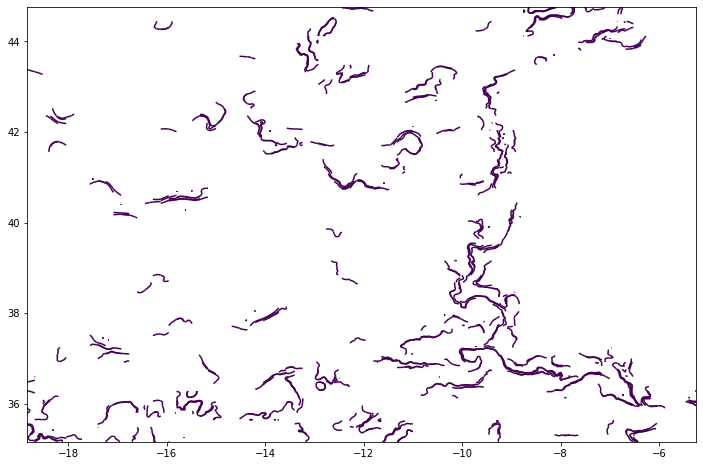

In [57]:
x1, y1 = CCA_SIED(data_xarray)

## Embelezar imagem

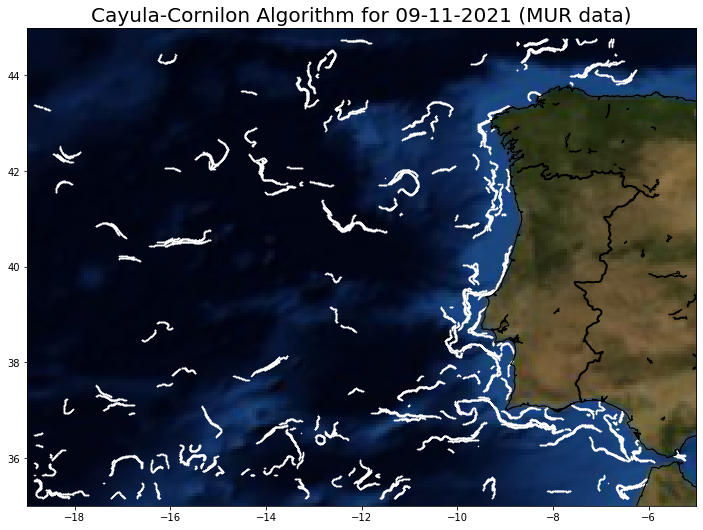

In [116]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,10))

m = Basemap(projection='cyl',                                #cyl -> stress com coordenadas nos axis
           llcrnrlat = 35,                      
           llcrnrlon = -19,                     
           urcrnrlat = 45,                      
           urcrnrlon = -5,                      
           resolution = 'f', suppress_ticks=False)

m.drawcoastlines()
#m.drawmapboundary(fill_color='blue')
m.drawcountries(linewidth=2)

#m.fillcontinents(color = 'darkgreen', lake_color='blue')   #por zonas continentais a verde
#m.etopo()      #topografia
m.bluemarble()
#m.shadedrelief()

x, y = m(x1, y1)

#m.plot(x1, y1,marker=None,color='m')
m.scatter(x, y, color='white', s= 0.3)


#m.drawparallels(np.arange(-90,90,2), labels = [1, 0, 0, 0])
#m.drawmeridians(np.arange(-180,180, 2), labels=[0,0,0,1])

plt.title('Cayula-Cornilon Algorithm for 09-11-2021 (MUR data)', fontsize=20)

plt.show()